### TMDB Box Office Prediction    

###### It is your job to predict the international box office revenue for each movie. For each id in the test set, you must predict the value of the revenue variable.

###### Submissions are evaluated on Root-Mean-Squared-Logarithmic-Error (RMSLE) between the predicted value and the actual revenue. Logs are taken to not overweight blockbuster revenue movies.[¶](http://localhost:8888/notebooks/Kaggle/MoviePredictions/Kaggle%20Movie%20Revenue%20Predictor.ipynb#Submissions-are-evaluated-on-Root-Mean-Squared-Logarithmic-Error-(RMSLE)-between-the-predicted-value-and-the-actual-revenue.-Logs-are-taken-to-not-overweight-blockbuster-revenue-movies.)

### Start Simply using just the data provided 
- https://www.kaggle.com/c/tmdb-box-office-prediction/data

In this notebook I will convey what I am seeing and thinking. An important part of data science is Subject Matter Expertise. I am definitely NOT a movie industry SME. I will rely on my gut and reading about the industry online. You will see more of my thought process than code.

In [44]:
### Here are the packages used in this notebook

import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns             # https://seaborn.pydata.org/index.html
from wordcloud import WordCloud   # https://pypi.org/project/wordcloud/

import pandasql                    # https://github.com/yhat/pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

from sklearn.preprocessing import MultiLabelBinarizer   #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
import ast                          # https://docs.python.org/3/library/ast.html

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest,chi2
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from types import FunctionType
from fastai.imports import *


import os
print(os.listdir("../input"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

['train.csv', 'sample_submission.csv', 'test.csv']


In [45]:
# First let's read the files in
# I like to do all my transformations on one file to prevent issues so I will create a file with both and tag as train/test
# Since I am doing log and normalize transformations across both files, results may vary if done only on the train file.
# release_date is in a horrible format - parse it on the way in 

train = pd.read_csv("../input/train.csv",parse_dates=["release_date"])
train['file']='train'
train = train.set_index('id')
print('train')
print(train.head(2))

test = pd.read_csv("../input/test.csv",parse_dates=["release_date"])
test['file']='test'
test = test.set_index('id')
print('test')
print(test.head(2))

both = pd.concat([train, test], sort=False)

print('both')
print(both.head(2))
      
submission = pd.read_csv("../input/sample_submission.csv")
print('train data types')  
train.dtypes
print('test data types')  
test.dtypes
print('both data types')  
both.dtypes


train
                                belongs_to_collection  ...     file
id                                                     ...         
1   [{'id': 313576, 'name': 'Hot Tub Time Machine ...  ...    train
2   [{'id': 107674, 'name': 'The Princess Diaries ...  ...    train

[2 rows x 23 columns]
test
                                  belongs_to_collection  ...   file
id                                                       ...       
3001  [{'id': 34055, 'name': 'Pokémon Collection', '...  ...   test
3002                                                NaN  ...   test

[2 rows x 22 columns]
both
                                belongs_to_collection  ...     file
id                                                     ...         
1   [{'id': 313576, 'name': 'Hot Tub Time Machine ...  ...    train
2   [{'id': 107674, 'name': 'The Princess Diaries ...  ...    train

[2 rows x 23 columns]
train data types


belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
Keywords                         object
cast                             object
crew                             object
revenue                           int64
file                             object
dtype: object

test data types


belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
Keywords                         object
cast                             object
crew                             object
file                             object
dtype: object

both data types


belongs_to_collection            object
budget                            int64
genres                           object
homepage                         object
imdb_id                          object
original_language                object
original_title                   object
overview                         object
popularity                      float64
poster_path                      object
production_companies             object
production_countries             object
release_date             datetime64[ns]
runtime                         float64
spoken_languages                 object
status                           object
tagline                          object
title                            object
Keywords                         object
cast                             object
crew                             object
revenue                         float64
file                             object
dtype: object

# Examine the Data

In [46]:
both.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 1 to 7398
Data columns (total 23 columns):
belongs_to_collection    1481 non-null object
budget                   7398 non-null int64
genres                   7375 non-null object
homepage                 2366 non-null object
imdb_id                  7398 non-null object
original_language        7398 non-null object
original_title           7398 non-null object
overview                 7376 non-null object
popularity               7398 non-null float64
poster_path              7396 non-null object
production_companies     6984 non-null object
production_countries     7241 non-null object
release_date             7397 non-null datetime64[ns]
runtime                  7392 non-null float64
spoken_languages         7336 non-null object
status                   7396 non-null object
tagline                  5938 non-null object
title                    7395 non-null object
Keywords                 6729 non-null object
cast      

In [47]:
both.describe(include='all')

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,file
count,1481,7.398000e+03,7375,2366,7398,7398,7398,7376,7398.000000,7396,6984,7241,7397,7392.000000,7336,7396,5938,7395,6729,7372,7360,3.000000e+03,7398
unique,750,NaN,1520,2331,7398,44,7265,7375,NaN,7396,5544,654,4703,NaN,761,3,5924,7239,6496,7339,7360,NaN,2
top,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.missionimpossible.com/,tt0480249,en,King Kong,No overview found.,NaN,/8HhS57TsCKU8QxPHgFMLw8gG3eW.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-09-10 00:00:00,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Hercules,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '59619ddd9251410bfa0cf8e5', 'de...",NaN,test
freq,26,NaN,614,4,1,6351,3,2,NaN,1,123,4339,10,NaN,4521,7385,3,3,56,34,1,NaN,4398
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1969-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2068-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.260146e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.514968,NaN,NaN,NaN,NaN,107.717262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07,NaN
std,NaN,3.694867e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.165794,NaN,NaN,NaN,NaN,21.480040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08,NaN
min,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN
25%,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,3.933124,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06,NaN


In [48]:
# Show me the nulls across both files - what am I dealing with here?
print(both.isnull().sum())

belongs_to_collection    5917
budget                      0
genres                     23
homepage                 5032
imdb_id                     0
original_language           0
original_title              0
overview                   22
popularity                  0
poster_path                 2
production_companies      414
production_countries      157
release_date                1
runtime                     6
spoken_languages           62
status                      2
tagline                  1460
title                       3
Keywords                  669
cast                       26
crew                       38
revenue                  4398
file                        0
dtype: int64


#### Before I start addressing the data, what columns do I THINK will be important?

What does my gut tell me?
- belongs_to_collection: I think so given the Avengers phenomenon
- budget: definitely though you do have your occasional outliers
- genre: definitely
- original_language: I would think a common language would appeal to the greater audience
- release_date: Definitely given inflation and trends in budgets
- runtime: better check that one, I'm not paying 10 dollars to see a 45 minute movie
- status: well, it does have to be released, doesn't it?
- title: I think so, but not positive on that one
- cast: do I know anyone on the cast?
- popularity: I know about movies from word of mouth or social media
- overview:

1.  #### examine belongs_to_collection  (object) , we are interested in 'name'

In [49]:
# Unsure if we are concerned WHICH collection, but we will assume that they wouldn't make another in the series if the first one bombed
# Using pandasql, one of my favorites though perforance can suffer. Dataset is small so let's give it a go
belongs_to_q = """
select 
count(*) as count, substr(belongs_to_collection, instr(belongs_to_collection,'name'), (instr(belongs_to_collection,'name')+40)) 
from both 
group by substr(belongs_to_collection, instr(belongs_to_collection,'name'), (instr(belongs_to_collection,'name')+40))
order by count(*) desc 
"""
belongs_to_o = pysqldf(belongs_to_q)
print(belongs_to_o)

# We see James Bond is the big leader. 
# I do see many collections of 1, meaning others in the collection are either spelled differently or not in this dataset.
# I would error on the side of just one-hotting the existence of a collection

     count substr(belongs_to_collection, instr(belongs_to_collection,'name'), (instr(belongs_to_collection,'name')+40))
0     5917                                               None                                                          
1       26  name': 'James Bond Collection', 'poster_path':...                                                          
2       12  name': 'Friday the 13th Collection', 'poster_p...                                                          
3        9  name': 'Pokémon Collection', 'poster_path': '/...                                                          
4        8  name': 'A Nightmare on Elm Street Collection',...                                                          
5        8  name': 'Halloween Collection', 'poster_path': ...                                                          
6        8  name': 'Harry Potter Collection', 'poster_path...                                                          
7        8  name': 'Star Wars Collection

In [50]:
# Since we are only interested in the existence of a name, let's one-hot it into a new column part_of_a_collection
both['part_of_a_collection'] = np.where(both['belongs_to_collection'].isna(), 0, 1)

collection_counts_q = """
select 
part_of_a_collection, count(*) as count
from both
group by part_of_a_collection
"""
collection_counts_o = pysqldf(collection_counts_q)
print(collection_counts_o)

   part_of_a_collection  count
0                     0   5917
1                     1   1481


2.  #### examine budget**  int64 non-null

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

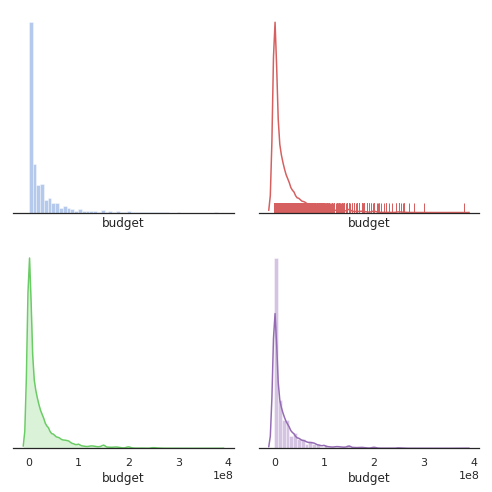

In [51]:
# What is the distribution of the budget?

# Viz with seaborn. It's visually pleasing
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(both['budget'],kde=False, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(both['budget'], hist=False, rug=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(both['budget'], hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])

# Plot a historgram and kernel density estimate
sns.distplot(both['budget'], color="m", ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()


In [52]:
# budget is very skewed. Makes sense. 
# I don't want to remove the outliers because those are the blockbusters (isn't that what we want to really know?)
# The evaluation also logs to minimize the effect of the blockbusters anyway
# How many of those budgets are zero (we know they aren't really zero...and are the same missing data)

budgets0_q = """
select 
 status, count(*) as count
from both
where budget = 0
group by status
"""
budgets0_o = pysqldf(budgets0_q)
print(budgets0_o)

# I though that the 0 values might correspond to films not yet released, that this isn't the case. This is a difficulty for sure

            status  count
0             None      2
1  Post Production      3
2         Released   2014
3          Rumored      4


In [53]:
# I will try a Sigmoid function to help
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y
sigmoid_results = sigmoid(both['budget'])
sigmoid_results.describe()

# That doesn't look good

count    7398.000000
mean        0.862896
std         0.222853
min         0.500000
25%         0.500000
50%         1.000000
75%         1.000000
max         1.000000
Name: budget, dtype: float64

In [54]:
# try log function
budget_log = np.log(both['budget'])
budget_log.describe

# divide by zero...nope

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


<bound method NDFrame.describe of id
1       16.454568
2       17.504390
3       15.009433
4       13.997832
5            -inf
6       15.894952
7       16.454568
8            -inf
9            -inf
10      15.607270
11      13.815511
12           -inf
13      16.523561
14      17.785802
15      18.440483
16      13.122363
17      17.073607
18           -inf
19      15.894952
20      17.281246
21      18.197537
22      15.201805
23           -inf
24           -inf
25           -inf
26           -inf
27      16.118096
28      16.213406
29      15.607270
30      17.622173
          ...    
7369    17.034386
7370    17.216708
7371         -inf
7372    17.822844
7373    18.951309
7374    14.403297
7375    16.588099
7376         -inf
7377    15.201805
7378    16.395727
7379    17.553180
7380         -inf
7381         -inf
7382    13.304685
7383    13.592367
7384    16.118096
7385    16.523561
7386    16.300417
7387         -inf
7388         -inf
7389    13.815511
7390         -inf
7391     

In [55]:
# Next up, Log + 1
budget_log1 = np.log(both['budget'] + 1)
budget_log1.describe()

# better - include a normalize
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

budget_log1_normalized = normalize(np.log(both['budget'] + 1))
budget_log1_normalized.describe()

# looks good
# set a new column as budget_log1_norm
both['budget_log1_norm'] = normalize(np.log(both['budget'] + 1))

count    7398.000000
mean       11.820750
std         7.465054
min         0.000000
25%         0.000000
50%        15.830414
75%        17.147715
max        19.755682
Name: budget, dtype: float64

count    7398.000000
mean        0.598347
std         0.377869
min         0.000000
25%         0.000000
50%         0.801309
75%         0.867989
max         1.000000
Name: budget, dtype: float64

3.  #### examine genre**  object json

In [56]:
genres_q = """
select 
count(*) as count, substr(genres, instr(genres,'name'), (instr(genres,'name')+40)) 
from both 
group by substr(genres, instr(genres,'name'), (instr(genres,'name')+40))
order by count(*) desc 
"""
genres_o = pysqldf(genres_q)
print(genres_o)

# I see that a movie can have multiple genres.
# Do I simply 1-hot out the results or dig deeper into the combinations?

     count substr(genres, instr(genres,'name'), (instr(genres,'name')+40))
0      614                                   name': 'Drama'}]             
1      477                                  name': 'Comedy'}]             
2      320  name': 'Action'}, {'id': 12, 'name': 'Adventur...             
3      287  name': 'Drama'}, {'id': 10749, 'name': 'Romanc...             
4      261  name': 'Comedy'}, {'id': 18, 'name': 'Drama'},...             
5      219     name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]             
6      212  name': 'Comedy'}, {'id': 10749, 'name': 'Roman...             
7      155  name': 'Action'}, {'id': 35, 'name': 'Comedy'}...             
8      143  name': 'Action'}, {'id': 80, 'name': 'Crime'},...             
9      130                             name': 'Documentary'}]             
10     122  name': 'Action'}, {'id': 18, 'name': 'Drama'},...             
11     122  name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]             
12     103   name': 'Dram

In [57]:
# While I would like to explore the combinations, let's start simply with 1-hots.
# Compliments to https://www.kaggle.com/liviuasnash/predict-movies-step-by-step/notebook
both['genres'] = both['genres'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))
both['genres']

id
1                          [{'id': 35, 'name': 'Comedy'}]
2       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
3                           [{'id': 18, 'name': 'Drama'}]
4       [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
5       [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
6       [{'id': 16, 'name': 'Animation'}, {'id': 12, '...
7       [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
8                     [{'id': 99, 'name': 'Documentary'}]
9       [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
10      [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...
11                          [{'id': 18, 'name': 'Drama'}]
12                         [{'id': 35, 'name': 'Comedy'}]
13                          [{'id': 18, 'name': 'Drama'}]
14      [{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...
15      [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
16      [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
17      [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...
18      [{'

In [58]:
# The EDA and feature engineering for the dict columns seems similar. Create a few basic common utilities
def print_few_values(col_name):
    print("Sample values for", col_name)
    both[col_name].head(5).apply(lambda x: print(x))
    
def dictionary_sizes(col_name):
    return (both[col_name].apply(lambda x: len(x)).value_counts())

def print_dictionary_sizes(col_name):
    print("\n===================================================")
    print("Distribution of sizes for", col_name)
    print(dictionary_sizes(col_name))
    
# returns a list of tuples of names for a given row of a column
def dict_name_list(d, name="name"):
    return ([i[name] for i in d] if d != {} else [])

# returns a list of tuples of the (id,name) pairs for a given row of a column
def dict_id_name_list(d, name="name"):
    return ([(i["id"],i[name]) for i in d] if d != {} else [])

# returns a list of names for a given column
def col_name_list(col_name, name="name"):
    # Get a list of lists of names
    name_list_list = list(both[col_name].apply(lambda x: dict_name_list(x, name)).values)
    # Merge into 1 list
    return ([i for name_list in name_list_list for i in name_list])

# returns a list of tuples of the (id,name) pairs for a given column
def col_id_name_list(col_name, name="name"):
    # Get a list of lists of (id,name) tuples
    tuple_list_list = list(both[col_name].apply(lambda x: dict_id_name_list(x, name)).values)
    # Merge into 1 list
    return ([i for tuple_list in tuple_list_list for i in tuple_list])

def get_names_counter(col_name, name="name"):
    name_list = col_name_list(col_name, name)
    return (collections.Counter(name_list))
    
def print_top_names(col_name, name="name"):
    print("\n===================================================")
    print("Top {0}s for {1}".format(name, col_name))
    c = get_names_counter(col_name, name)
    print(c.most_common(20))
    
def EDA_dict(col_name):
    print_few_values(col_name)
    print_dictionary_sizes(col_name)
    print_top_names(col_name)
    
def add_dict_size_column(col_name):
    both[col_name + "_size"] = both[col_name].apply(lambda x: len(x) if x != {} else 0)

def add_dict_id_column(col_name):
    c = col_name + "_id"
    both[c] = both[col_name].apply(lambda x: x[0]["id"] if x != {} else 0)
    both[c] = both[c].astype("category")

# for each of the top values in the dictionary, add an column indicating if the row belongs to it
def add_dict_indicator_columns(col_name):
    c = get_names_counter(col_name)
    top_names = [x[0] for x in c.most_common(20)]
    for name in top_names:
        both[col_name + "_" + name] = both[col_name].apply(lambda x: name in dict_name_list(x))
        
def drop_column(col_name):
    both.drop([col_name], axis=1, inplace=True)
    
def feature_engineer_dict(col_name):
    add_dict_size_column(col_name)
    max_size = dictionary_sizes(col_name).index.max()
    if max_size == 1:
        add_dict_id_column(col_name)
    else:
        add_dict_indicator_columns(col_name)
    drop_column(col_name)
    
def encode_column(col_name):
    lbl = LabelEncoder()
    lbl.fit(list(both[col_name].values)) 
    both[col_name] = lbl.transform(list(both[col_name].values))
    
col_name="genres"
EDA_dict(col_name)

feature_engineer_dict(col_name)

Sample values for genres
[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]

Distribution of sizes for genres
2    2379
3    2208
1    1488
4     967
5     280
6      48
0      23
7       4
8       1
Name: genres, dtype: int64

Top names for genres
[('Drama', 3676), ('Comedy', 2605), ('Thriller', 1869), ('Action', 1735), ('Romance', 1435), ('Adventure', 1116), ('Crime', 1084), ('Science Fiction', 744), ('Horror', 735), ('Family', 675), ('Fantasy', 628), ('Mystery', 550), ('Animation', 382), ('History', 295), ('Music', 267), ('War', 243), ('Documentary', 221), ('Western', 117), ('Foreign', 84), ('TV Movie', 1)]


In [59]:
both.columns

Index(['belongs_to_collection', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'revenue', 'file',
       'part_of_a_collection', 'budget_log1_norm', 'genres_size',
       'genres_Drama', 'genres_Comedy', 'genres_Thriller', 'genres_Action',
       'genres_Romance', 'genres_Adventure', 'genres_Crime',
       'genres_Science Fiction', 'genres_Horror', 'genres_Family',
       'genres_Fantasy', 'genres_Mystery', 'genres_Animation',
       'genres_History', 'genres_Music', 'genres_War', 'genres_Documentary',
       'genres_Western', 'genres_Foreign', 'genres_TV Movie'],
      dtype='object')

In [60]:
# get rid of the sames in science fiction and tv movie...not helpful
both.columns = ['belongs_to_collection', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'revenue', 'file',
       'part_of_a_collection', 'budget_log1_norm', 'genres_size',
       'genres_Drama', 'genres_Comedy', 'genres_Thriller', 'genres_Action',
       'genres_Romance', 'genres_Adventure', 'genres_Crime',
       'genres_Science_Fiction', 'genres_Horror', 'genres_Family',
       'genres_Fantasy', 'genres_Mystery', 'genres_Animation',
       'genres_History', 'genres_Music', 'genres_War', 'genres_Documentary',
       'genres_Western', 'genres_Foreign', 'genres_TV_Movie']

In [61]:
# Convert T/F to 1/0 for future matching
both.genres_Drama = both.genres_Drama.astype(int)
both.genres_Comedy = both.genres_Comedy.astype(int)
both.genres_Thriller = both.genres_Thriller.astype(int)
both.genres_Action = both.genres_Action.astype(int)
both.genres_Romance = both.genres_Romance.astype(int)
both.genres_Adventure = both.genres_Adventure.astype(int)
both.genres_Crime = both.genres_Crime.astype(int)
both.genres_Science_Fiction = both.genres_Science_Fiction.astype(int)
both.genres_Horror = both.genres_Horror.astype(int)
both.genres_Family = both.genres_Family.astype(int)
both.genres_Fantasy = both.genres_Fantasy.astype(int)
both.genres_Mystery = both.genres_Mystery.astype(int)
both.genres_Animation = both.genres_Animation.astype(int)
both.genres_History = both.genres_History.astype(int)
both.genres_Music = both.genres_Music.astype(int)
both.genres_War = both.genres_War.astype(int)
both.genres_Documentary = both.genres_Documentary.astype(int)
both.genres_Western = both.genres_Western.astype(int)
both.genres_Foreign = both.genres_Foreign.astype(int)
both.genres_TV_Movie = both.genres_TV_Movie.astype(int)
both.head(10)

,belongs_to_collection,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,file,part_of_a_collection,budget_log1_norm,genres_size,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Adventure,genres_Crime,genres_Science_Fiction,genres_Horror,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,genres_War,genres_Documentary,genres_Western,genres_Foreign,genres_TV_Movie
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-02-20,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651.0,train,1,0.832903,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2004-08-06,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435.0,train,1,0.886043,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,NaN,3300000,http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2014-10-10,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000.0,train,0,0.759753,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,1200000,http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",2012-03-09,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000.0,train,0,0.708547,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,NaN,0,NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2009-02-05,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970.0,train,0,0.000000,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,NaN,8000000,NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,NaN,NaN,1987-08-06,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638.0,train,0,0.8045

In [62]:
# 20 top revenue genre combos
g_rev = """
with list as 
(select avg(revenue) as avg_revenue
,    genres_Drama, genres_Comedy, genres_Thriller, genres_Action,
       genres_Romance, genres_Adventure, genres_Crime,
       genres_Science_Fiction, genres_Horror, genres_Family,
       genres_Fantasy, genres_Mystery, genres_Animation,
       genres_History, genres_Music, genres_War, genres_Documentary,
       genres_Western, genres_Foreign, genres_TV_Movie
       from both 
       group by
       genres_Drama, genres_Comedy, genres_Thriller, genres_Action,
       genres_Romance, genres_Adventure, genres_Crime,
       genres_Science_Fiction, genres_Horror, genres_Family,
       genres_Fantasy, genres_Mystery, genres_Animation,
       genres_History, genres_Music, genres_War, genres_Documentary,
       genres_Western, genres_Foreign, genres_TV_Movie
  )
  select row_number()  over (
       order by avg_revenue asc) as row_number
  , genres_Drama, genres_Comedy, genres_Thriller, genres_Action,
       genres_Romance, genres_Adventure, genres_Crime,
       genres_Science_Fiction, genres_Horror, genres_Family,
       genres_Fantasy, genres_Mystery, genres_Animation,
       genres_History, genres_Music, genres_War, genres_Documentary,
       genres_Western, genres_Foreign, genres_TV_Movie
       from list
       
       
"""
genre_revenue = pysqldf(g_rev)
genre_revenue.genres_Drama = genre_revenue.genres_Drama.astype(int)
genre_revenue.genres_Comedy = genre_revenue.genres_Comedy.astype(int)
genre_revenue.genres_Thriller = genre_revenue.genres_Thriller.astype(int)
genre_revenue.genres_Action = genre_revenue.genres_Action.astype(int)
genre_revenue.genres_Romance = genre_revenue.genres_Romance.astype(int)
genre_revenue.genres_Adventure = genre_revenue.genres_Adventure.astype(int)
genre_revenue.genres_Crime = genre_revenue.genres_Crime.astype(int)
genre_revenue.genres_Science_Fiction = genre_revenue.genres_Science_Fiction.astype(int)
genre_revenue.genres_Horror = genre_revenue.genres_Horror.astype(int)
genre_revenue.genres_Family = genre_revenue.genres_Family.astype(int)
genre_revenue.genres_Fantasy = genre_revenue.genres_Fantasy.astype(int)
genre_revenue.genres_Mystery = genre_revenue.genres_Mystery.astype(int)
genre_revenue.genres_Animation = genre_revenue.genres_Animation.astype(int)
genre_revenue.genres_History = genre_revenue.genres_History.astype(int)
genre_revenue.genres_Music = genre_revenue.genres_Music.astype(int)
genre_revenue.genres_War = genre_revenue.genres_War.astype(int)
genre_revenue.genres_Documentary = genre_revenue.genres_Documentary.astype(int)
genre_revenue.genres_Western = genre_revenue.genres_Western.astype(int)
genre_revenue.genres_Foreign = genre_revenue.genres_Foreign.astype(int)
genre_revenue.genres_TV_Movie = genre_revenue.genres_TV_Movie.astype(int)
genre_revenue.tail(20)

,row_number,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Adventure,genres_Crime,genres_Science_Fiction,genres_Horror,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,genres_War,genres_Documentary,genres_Western,genres_Foreign,genres_TV_Movie
796,797,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
797,798,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
798,799,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
799,800,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0
800,801,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
801,802,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
802,803,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
803,804,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
804,805,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
805,806,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


4.  #### examine original_language

In [63]:
olang_q = """
select 
count(*) as count, original_language
from both 
group by original_language
order by count(*) desc 
"""
olang_o = pysqldf(olang_q)
print(olang_o)

# overwhelmingly English. I'm not sure if this is enough variation to be useful.

    count original_language
0    6351                en
1     199                fr
2     118                hi
3     109                ru
4      95                es
5      90                ja
6      56                it
7      49                de
8      49                ko
9      46                zh
10     41                cn
11     31                ta
12     20                sv
13     17                da
14     13                pt
15     12                ml
16     11                nl
17      9                ro
18      9                te
19      9                tr
20      6                he
21      5                fa
22      5                no
23      5                pl
24      5                th
25      4                fi
26      4                hu
27      3                bn
28      3                cs
29      3                el
30      3                id
31      3                sr
32      2                bm
33      2                ur
34      2           

In [64]:
both['is_English'] = 0 
both.loc[ both['original_language'] == "en" ,"is_English"] = 1

5.  #### examine popularity

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

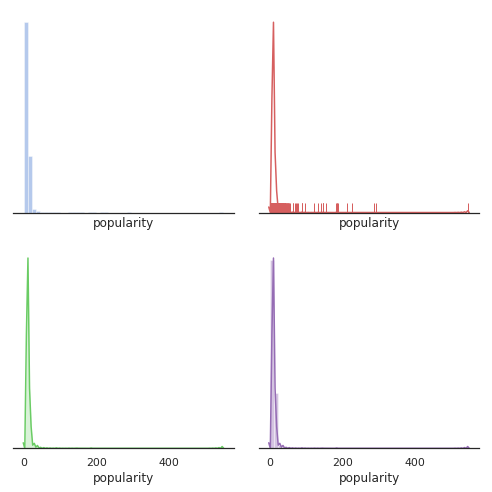

In [65]:
# What is the distribution of the popularity?

# Viz with seaborn. It's visually pleasing
sns.set(style="white", palette="muted", color_codes=True)

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(both['popularity'],kde=False, color="b", ax=axes[0, 0])

# Plot a kernel density estimate and rug plot
sns.distplot(both['popularity'], hist=False, rug=True, color="r", ax=axes[0, 1])

# Plot a filled kernel density estimate
sns.distplot(both['popularity'], hist=False, color="g", kde_kws={"shade": True}, ax=axes[1, 0])

# Plot a historgram and kernel density estimate
sns.distplot(both['popularity'], color="m", ax=axes[1, 1])

plt.setp(axes, yticks=[])
plt.tight_layout()

In [66]:
# commenting out for efficiency

# popularity in relation to revenue
#pop_rev = sns.swarmplot(x='popularity', y='revenue', data=both)
#pop_rev

# More popular = More revenue? Shocker!
# It is skewed so let's log1 normalize it to a new column popularity_log1_norm

both['popularity_log1_norm'] = normalize(np.log(both['popularity'] + 1))



6.  #### examine release_date

In [67]:
# 1 test row without a date - that will probably need to be fixed or removed
# 3829
# Thinking about it, do not remove.  Then the shapes will not align. 
# Looking up the information:
# https://www.imdb.com/title/tt0210130/?ref_=nv_sr_1?ref_=nv_sr_1
# 20 March 2001

#both['release_date']=both['release_date'].fillna('3/20/2001')

# I want to break the date parts out..... 
both['release_date']
both['release_date'] = pd.to_datetime(both['release_date'], format='%m/%d/%y')
both['release_year'] = both.release_date.dt.year.fillna(2001)
both['release_month'] = both.release_date.dt.month.fillna(3)
both['release_day'] = both.release_date.dt.day.fillna(20)
both['release_day_of_week'] = both.release_date.dt.dayofweek.fillna(1)
both['release_quarter'] = both.release_date.dt.quarter.fillna(1) 

id
1      2015-02-20
2      2004-08-06
3      2014-10-10
4      2012-03-09
5      2009-02-05
6      1987-08-06
7      2012-08-30
8      2004-01-15
9      1996-02-16
10     2003-04-16
11     1976-11-21
12     1987-07-10
13     1999-09-15
14     2005-03-04
15     2002-06-20
16     2010-10-06
17     2005-08-04
18     2013-12-25
19     2011-02-02
20     2005-08-02
21     1998-04-03
22     1982-08-13
23     2012-07-28
24     2011-09-02
25     2006-09-09
26     1992-10-23
27     1997-09-08
28     2013-09-07
29     1986-08-08
30     2002-04-07
          ...    
7369   2016-01-01
7370   2008-03-14
7371   1999-10-15
7372   2010-11-23
7373   2011-11-22
7374   1976-11-03
7375   1991-05-24
7376   2002-09-06
7377   1970-06-22
7378   2014-09-10
7379   2005-09-16
7380   2015-04-30
7381   2016-06-03
7382   1970-03-26
7383   2006-11-23
7384   2012-09-11
7385   1987-08-14
7386   2001-12-21
7387   1991-06-28
7388   2013-09-11
7389   2006-01-30
7390   2013-03-22
7391   1991-06-21
7392   2009-11-06
7393   

In [68]:
# This is a check to be sure I don't have any null date fields

print(both['release_quarter'].isnull().sum())


0


7.  #### examine runtime

In [69]:
# Runtime and Revenue?
# Replace NaN with zeroes

both['runtime'] = both['runtime'].fillna




#### List of the columns and their tranformations before modelling and effect on rows

 - id                          : drop
 - belongs_to_collection       : 1-hot to 'part_of_collection'
 - budget                      : log1 normalized to 'budget_log1_norm'
 - genres                      : new genre_* columns added as 1-hot
 - homepage                    : drop
 - imdb_id                     : drop
 - original_language           : drop for now
 - original_title              : drop for now
 - overview                    : NLP - drop by now but I do have some wordCloud logic below
 - popularity                  : log1 normalized to 'popularity_log1_norm'
 - poster_path                 : drop
 - production_companies        : drop for now
 - production_countries        : drop for now
 - release_date                : fix the layout and add new breakdown columns
 - runtime                     :
 - spoken_languages            : drop for now
 - status                      : only want released movies
 - tagline                     : drop
 - title                       : drop for now
 - Keywords                    : drop for now
 - cast                        : drop
 - crew                        : drop
 - revenue                     : This is the target
 - file                        : drop after split back to train and test

In [70]:
both.columns

Index(['belongs_to_collection', 'budget', 'homepage', 'imdb_id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'revenue', 'file',
       'part_of_a_collection', 'budget_log1_norm', 'genres_size',
       'genres_Drama', 'genres_Comedy', 'genres_Thriller', 'genres_Action',
       'genres_Romance', 'genres_Adventure', 'genres_Crime',
       'genres_Science_Fiction', 'genres_Horror', 'genres_Family',
       'genres_Fantasy', 'genres_Mystery', 'genres_Animation',
       'genres_History', 'genres_Music', 'genres_War', 'genres_Documentary',
       'genres_Western', 'genres_Foreign', 'genres_TV_Movie', 'is_English',
       'popularity_log1_norm', 'release_year', 'release_month', 'release_day',
       'release_day_of_week', 'release_quarter'],
      dtype='object')

In [71]:
# Create a dataframe with only the columns I want and move revenue to the end

both_final = both[['file', 
       'part_of_a_collection', 'budget_log1_norm', 'genres_size',
       'genres_Drama', 'genres_Comedy', 'genres_Thriller', 'genres_Action',
       'genres_Romance', 'genres_Adventure', 'genres_Crime',
       'genres_Science_Fiction', 'genres_Horror', 'genres_Family',
       'genres_Fantasy', 'genres_Mystery', 'genres_Animation',
       'genres_History', 'genres_Music', 'genres_War', 'genres_Documentary',
       'genres_Western', 'genres_Foreign', 'genres_TV_Movie',
       'popularity_log1_norm', 'release_year', 'release_month', 'release_day',
       'release_day_of_week', 'release_quarter','is_English','revenue']]



both_final

,file,part_of_a_collection,budget_log1_norm,genres_size,genres_Drama,genres_Comedy,genres_Thriller,genres_Action,genres_Romance,genres_Adventure,genres_Crime,genres_Science_Fiction,genres_Horror,genres_Family,genres_Fantasy,genres_Mystery,genres_Animation,genres_History,genres_Music,genres_War,genres_Documentary,genres_Western,genres_Foreign,genres_TV_Movie,popularity_log1_norm,release_year,release_month,release_day,release_day_of_week,release_quarter,is_English,revenue
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,train,1,0.832903,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.321048,2015.0,2.0,20.0,4.0,1.0,1,12314651.0
2,train,1,0.886043,4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.352695,2004.0,8.0,6.0,4.0,3.0,1,95149435.0
3,train,0,0.759753,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.662578,2014.0,10.0,10.0,4.0,4.0,1,13092000.0
4,train,0,0.708547,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.226583,2012.0,3.0,9.0,4.0,1.0,0,16000000.0
5,train,0,0.000000,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.121222,2009.0,2.0,5.0,3.0,1.0,0,3923970.0
6,train,0,0.804576,3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.088116,1987.0,8.0,6.0,3.0,3.0,1,3261638.0
7,train,0,0.832903,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.335273,2012.0,8.0,30.0,3.0,3.0,1,85446075.0
8,train,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.171468,2004.0,1.0,15.0,3.0,1.0,1,2586511.0
9,train,1,0.000000,5,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0.327749,1996.0,2.0,16.0,4.0,1.0,1,34327391.0


In [72]:
# Time to put split the data into train and test files
# Then drop the file column, we don't need that anymore

train_final_1 = both_final[(both_final['file'] == "train")]
train_final_1 = train_final_1.drop(columns=['file'])

test_final_1 = both_final[(both_final['file'] == "test")]
test_final_1 = test_final_1.drop(columns=['file'])

y_train = train_final_1[['revenue']]
y_train

,revenue
id,
1,12314651.0
2,95149435.0
3,13092000.0
4,16000000.0
5,3923970.0
6,3261638.0
7,85446075.0
8,2586511.0
9,34327391.0


In [73]:
# Do I have nulls in there??
# Yes, test revenue
test_final_1.sum(), test_final_1.min(), test_final_1.max()
test_final_1['revenue'] = 1000
test_final_1.sum(), test_final_1.min(), test_final_1.max()

(part_of_a_collection      8.770000e+02
 budget_log1_norm          2.622734e+03
 genres_size               1.095100e+04
 genres_Drama              2.145000e+03
 genres_Comedy             1.577000e+03
 genres_Thriller           1.080000e+03
 genres_Action             9.940000e+02
 genres_Romance            8.640000e+02
 genres_Adventure          6.770000e+02
 genres_Crime              6.150000e+02
 genres_Science_Fiction    4.540000e+02
 genres_Horror             4.340000e+02
 genres_Family             4.150000e+02
 genres_Fantasy            3.960000e+02
 genres_Mystery            3.250000e+02
 genres_Animation          2.410000e+02
 genres_History            1.630000e+02
 genres_Music              1.670000e+02
 genres_War                1.430000e+02
 genres_Documentary        1.340000e+02
 genres_Western            7.400000e+01
 genres_Foreign            5.300000e+01
 genres_TV_Movie           0.000000e+00
 popularity_log1_norm      1.384457e+03
 release_year              8.815673e+06


(part_of_a_collection      8.770000e+02
 budget_log1_norm          2.622734e+03
 genres_size               1.095100e+04
 genres_Drama              2.145000e+03
 genres_Comedy             1.577000e+03
 genres_Thriller           1.080000e+03
 genres_Action             9.940000e+02
 genres_Romance            8.640000e+02
 genres_Adventure          6.770000e+02
 genres_Crime              6.150000e+02
 genres_Science_Fiction    4.540000e+02
 genres_Horror             4.340000e+02
 genres_Family             4.150000e+02
 genres_Fantasy            3.960000e+02
 genres_Mystery            3.250000e+02
 genres_Animation          2.410000e+02
 genres_History            1.630000e+02
 genres_Music              1.670000e+02
 genres_War                1.430000e+02
 genres_Documentary        1.340000e+02
 genres_Western            7.400000e+01
 genres_Foreign            5.300000e+01
 genres_TV_Movie           0.000000e+00
 popularity_log1_norm      1.384457e+03
 release_year              8.815673e+06


# #1 Simple Regression Model 

Result is 2.66 on the leaderboard... eh

In [74]:
y_train = y_train.values

In [75]:
# 1.) Remove table meta data, column names etc. → Just use values for prediction.
X_train = train_final_1.values
#y_train = y_train.values

X_test  = test_final_1.values

# Update:) Scale

X_scaler = StandardScaler()
X_train  = X_scaler.fit_transform(X_train)
X_test   = X_scaler.transform(X_test)
y_train  = np.log(y_train)
y_scaler = MinMaxScaler((0,1))

In [76]:
# Do I have nulls in there??

X_train.sum(), X_train.min(), X_train.max()
y_train.sum(), y_train.min(), y_train.max()
X_test.sum(), X_test.min(), X_test.max()


(-1.7688073228327994e-11, -2.6638247443643714, 54.763126280372276)

(47879.68341120126, 0.0, 21.141685280815704)

(-1814.7532221495178, -2.6638247443643714, 9.786429049882653)

In [77]:
y_train  = y_scaler.fit_transform(y_train).ravel() # transform and convert column-vector y to a 1d array

# Update:) Create Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=56)

In [79]:
# The data is prepped, now to fit and predict.
# Nice kernel with more details : https://www.kaggle.com/alexandermelde/code-template-for-simple-regression-prediction/data

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

tr = tree.DecisionTreeRegressor()

est = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1,
     max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)

sgd1 = SGDRegressor(alpha=0.0001, fit_intercept=False, max_iter=100, early_stopping=True, n_iter_no_change=5, epsilon=0.1,
                   loss='squared_loss')

LGB = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=30, 
                             min_child_samples=100,
                             learning_rate=0.01,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.9,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=2729, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

# 2.) Calculate the coefficients of the linear regression / "Train"
#reg     = KNeighborsRegressor().fit(X_train, y_train)
reg     = LGB.fit(X_train, y_train)

# 3.) Define functions to calculate a score
def score_function(y_true, y_pred):
    # see https://www.kaggle.com/c/tmdb-box-office-prediction/overview/evaluation
    # we use Root Mean squared logarithmic error (RMSLE) regression loss
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

def score_function2(y_true, y_pred):
    # alternative implementation
    y_pred = np.where(y_pred>0, y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
    
# 4.) Apply the regression model on the prepared train, validation and test set and invert the logarithmic scaling
y_train_pred  = np.exp(y_scaler.inverse_transform(np.reshape(reg.predict(X_train), (-1,1))))
y_val_pred    = np.exp(y_scaler.inverse_transform(np.reshape(reg.predict(X_val), (-1,1))))
y_test_pred   = np.exp(y_scaler.inverse_transform(np.reshape(reg.predict(X_test), (-1,1))))
                   
# 5.) Print the RMLS error on training, validation and test set. it should be as low as possible
print("RMLS Error on Training Dataset:\t", score_function(y_train , y_train_pred), score_function2(y_train , y_train_pred))
print("RMLS Error on Validation Dataset:\t", score_function(y_val , y_val_pred), score_function2(y_val , y_val_pred))
print("RMLS Error on Provided Test Dataset:\t mystery!")

RMLS Error on Training Dataset:	 15.623141909969396 15.605248036469964
RMLS Error on Validation Dataset:	 15.779742496373743 15.762788777313922
RMLS Error on Provided Test Dataset:	 mystery!


KneighborsRegressor
RMLS Error on Training Dataset:	 15.547592983884789 15.539551960636024
RMLS Error on Validation Dataset:	 15.70143937791011 15.694826211333938
RMLS Error on Provided Test Dataset:	 mystery!

KernelRidge
RMLS Error on Training Dataset:	 15.497063904422337 15.485354018649339
RMLS Error on Validation Dataset:	 15.584945042892722 15.574921228069943
RMLS Error on Provided Test Dataset:	 mystery!



svr   
RMLS Error on Training Dataset:	 14.986179084900266 14.976100987536602
RMLS Error on Validation Dataset:	 15.1306913168581 15.121250850703301
RMLS Error on Provided Test Dataset:	 mystery!  3.07075

tree 
RMLS Error on Training Dataset:	 15.626489093924114 15.608505921209446
RMLS Error on Validation Dataset:	 15.781387350831444 15.764270359722536
RMLS Error on Provided Test Dataset:	 mystery!

GRradientBoostingRegression
RMLS Error on Training Dataset:	 15.624023710355614 15.606106913849564
RMLS Error on Validation Dataset:	 15.77976526199863 15.76267975857145

SDG Regressor
RMLS Error on Training Dataset:	 1.6505243240191463 1.6255415812775773
RMLS Error on Validation Dataset:	 1.3693205074018826 1.340932778473505
RMLS Error on Provided Test Dataset:	 mystery!
RMLS Error on Training Dataset:	 2.249698339443753 2.230180102897242
RMLS Error on Validation Dataset:	 2.049057861691203 2.0282387315895387
RMLS Error on Provided Test Dataset:	 14.97801   Overfitting

swinging pedulum
RMLS Error on Training Dataset:	 93.5929418826801 93.59325525330341
RMLS Error on Validation Dataset:	 94.48388810814194 94.48491750861014
RMLS Error on Provided Test Dataset:	 mystery!

RMLS Error on Training Dataset:	 11.025184846538503 11.021722849659747
RMLS Error on Validation Dataset:	 10.938330718432164 10.932387972056876
RMLS Error on Provided Test Dataset:	 99.56452     whoah!!!!!!

lgb 
RMLS Error on Training Dataset:	 15.623141909969396 15.605248036469964
RMLS Error on Validation Dataset:	 15.779742496373743 15.762788777313922
RMLS Error on Provided Test Dataset:	 mystery!

In [ ]:
# Make sure my shapes are in order
# If they are not, go back through your code. Did you remove any rows during prep?

test.shape
y_test_pred.shape
test.index

In [ ]:
test.columns

In [ ]:
# 1.) Add the predicted values to the original test data
df_test = test.assign(revenue=y_test_pred)

# 2.) Extract a table of ids and their revenue predictions

output = df_test.loc[:, lambda df_test: [ 'revenue']]
output

# 3.) save that table to a csv file
output.to_csv("submission1c.csv")

# 4.) take a look
pd.read_csv("submission1c.csv").head(5)